## Catalog
<a href=#p1>1. Import Packages and Import Data</a>

<a href=#p2>2. Data Preprocessing</a>

<a href=#p3>3. IPTW </a>

<a name='p1' /></a>
## 1. Import Packages and Import Data

This part mainly contains: 1. connections between Google Colab and Google Drive, 2. import packages, 3. import data

In [ ]:
# This block is about building connections between Google Colab and personal google drive.
# Taken and amended from this stackoverflow answer: https://stackoverflow.com/questions/47744131/colaboratory-can-i-access-to-my-google-drive-folder-and-file
# I give full credits to the author.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
import os
os.chdir("drive/Colab Notebooks/SPH") # in my personal google drive, I built a separate folder called "SPH" to store all related documents

In [ ]:
import numpy as np
import pandas as pd
import pandasql as ps
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed # for parallel processing

In [ ]:
sph_df=pd.read_excel('SPH.xlsx')

<a name='p2' /></a>
## 2. Data Preprocessing
This part includes drop missing values, drop duplicate records, binning and rename columns

In [ ]:
sph_df.columns

Index(['PatNo', 'icustay_id', 'los', 'discharge_location', 'ethnicity',
       'White', 'Black', 'AmerIndian_AlaskaN', 'Asian', 'NHawaiian_OtherPI',
       'Hispanic_Latino', 'Others', 'MultiRaceEthnicity',
       'hospital_expire_flag', 'age', 'gender', 'gender_Male', 'sofa',
       'apsiii', 'oasis', 'aniongap_min', 'bicarbonate_min', 'lactate_min',
       'min_gcs', 'elixhauser_vanwalraven', 'vaso_treatment',
       'propensityscore', 'propensityblock', 'comsup', 'inhospmortality_NNM',
       '_merge_inhospmortality_NNM', 'los_NNM', '_merge_los_NNM'],
      dtype='object')

In [ ]:
sph_df.drop(columns=['propensityscore', 'propensityblock', 'comsup', 'inhospmortality_NNM',
       '_merge_inhospmortality_NNM', 'los_NNM', '_merge_los_NNM'],inplace=True)

In [ ]:
sph_df_clean=sph_df.dropna() # drop nans

In [ ]:
len(sph_df_clean)

3229

In [ ]:
len(sph_df_clean['icustay_id'].unique())

2637

In [ ]:
q = "select d1.* from sph_df_clean d1 where d1.PatNo = (select max(d2.PatNo) from sph_df_clean d2 where d2.icustay_id = d1.icustay_id);"
sph_df_clean=ps.sqldf(q, locals()) # drop duplicate records

In [ ]:
len(sph_df_clean)

2637

In [ ]:
sph_df_clean.columns

Index(['PatNo', 'icustay_id', 'los', 'discharge_location', 'ethnicity',
       'White', 'Black', 'AmerIndian_AlaskaN', 'Asian', 'NHawaiian_OtherPI',
       'Hispanic_Latino', 'Others', 'MultiRaceEthnicity',
       'hospital_expire_flag', 'age', 'gender', 'gender_Male', 'sofa',
       'apsiii', 'oasis', 'aniongap_min', 'bicarbonate_min', 'lactate_min',
       'min_gcs', 'elixhauser_vanwalraven', 'vaso_treatment'],
      dtype='object')

In [ ]:
sph_df_clean['disc_loc_clas']=np.nan # create a new column to bin different discharge locations to different classes

In [ ]:
sph_df_clean['discharge_location'].unique()

array(['HOME HEALTH CARE', 'SNF', 'LONG TERM CARE HOSPITAL',
       'REHAB/DISTINCT PART HOSP', 'DEAD/EXPIRED', 'SHORT TERM HOSPITAL',
       'HOSPICE-HOME', 'HOME', 'HOSPICE-MEDICAL FACILITY',
       'DISC-TRAN CANCER/CHLDRN H', 'ICF', 'SNF-MEDICAID ONLY CERTIF',
       'OTHER FACILITY', 'DISCH-TRAN TO PSYCH HOSP',
       'LEFT AGAINST MEDICAL ADVI'], dtype=object)

In [ ]:
# 0: palliation/death, 1: fit for discharge, 2: specialised care required
disc_mapping={'DEAD/EXPIRED':0,'HOSPICE-HOME':0,'HOSPICE-MEDICAL FACILITY':0,'HOME HEALTH CARE':1,'HOME':1,'SNF':2, 'LONG TERM CARE HOSPITAL':2,
       'REHAB/DISTINCT PART HOSP':2, 'SHORT TERM HOSPITAL':2,
       'DISC-TRAN CANCER/CHLDRN H':2, 'ICF':2, 'SNF-MEDICAID ONLY CERTIF':2,
       'OTHER FACILITY':2, 'DISCH-TRAN TO PSYCH HOSP':2,
       'LEFT AGAINST MEDICAL ADVI':2}

In [ ]:
for i in sph_df_clean['discharge_location'].unique():
  sph_df_clean['disc_loc_clas'].where(sph_df_clean['discharge_location']!=i,disc_mapping[i],inplace=True) # create feature across all the dataset

In [ ]:
sph_df_clean['disc_loc_clas'] # check the results

0       1.0
1       2.0
2       2.0
3       1.0
4       2.0
       ... 
2632    2.0
2633    2.0
2634    2.0
2635    2.0
2636    2.0
Name: disc_loc_clas, Length: 2637, dtype: float64

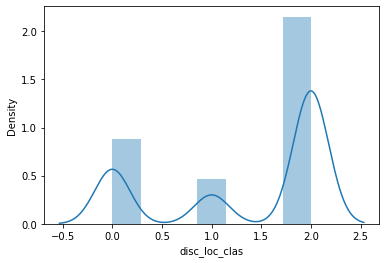

In [ ]:
sns.distplot(sph_df_clean['disc_loc_clas'])

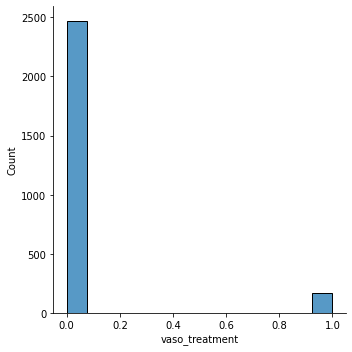

In [ ]:
sns.displot(data=sph_df_clean,x='vaso_treatment') # check vaso treatment distribution

In [ ]:
sph_df_clean.drop(columns=['PatNo', 'icustay_id','ethnicity','gender','discharge_location'],inplace=True,errors='ignore')

In [ ]:
sph_df_clean.rename(columns={'White':'wh', 'Black':'bl', 'AmerIndian_AlaskaN':'inal', 'Asian':'as',
       'NHawaiian_OtherPI':'hw', 'Hispanic_Latino':'lat', 'Others':'oth', 'MultiRaceEthnicity':'mul','in_al':'inal'},inplace=True,errors='ignore')

In [ ]:
sph_df_clean.rename(columns={
       'hospital_expire_flag':'expire','gender_Male':'gender',
       'aniongap_min':'aniongap', 'bicarbonate_min':'bicarbonate', 'lactate_min':'lactate', 'min_gcs':'gcs',
       'elixhauser_vanwalraven':'comor', 'vaso_treatment':'vaso', 'disc_loc_clas':'class'},inplace=True,errors='ignore')

In [ ]:
sph_df_clean.columns

Index(['los', 'wh', 'bl', 'inal', 'as', 'hw', 'lat', 'oth', 'mul', 'expire',
       'age', 'gender', 'sofa', 'apsiii', 'oasis', 'aniongap', 'bicarbonate',
       'lactate', 'gcs', 'comor', 'vaso', 'class'],
      dtype='object')

In [ ]:
df0=sph_df_clean.copy()
df0['class'].replace({2:1},inplace=True) # currently we binarize three classes into two classes: death or non-death
df0=df0.astype({'class': 'int64'})

In [ ]:
df0['class'].unique()

array([1, 0])

<a name='p3' /></a>
## 3. IPTW

In [ ]:
# use logistic regression to estimate propensity score
from sklearn.linear_model import LogisticRegression

T = 'vaso'
Y = 'class'
X = df0.drop(columns=[T, Y])

ps_model = LogisticRegression().fit(X,df0[T])

data_ps = df0.assign(propensity_score=ps_model.predict_proba(X)[:, 1])

data_ps[["vaso", "class", "propensity_score"]].head()

,vaso,class,propensity_score
0,0,1,0.059848
1,0,1,0.033135
2,0,1,0.040629
3,0,1,0.004837
4,0,1,0.132385


In [ ]:
weight_t = 1/data_ps.query("vaso==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("vaso==0")["propensity_score"])
print("Original Sample Size", df0.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 2637
Treated Population Sample Size 2095.4540975740915
Untreated Population Sample Size 2671.0497857433165


In [ ]:
dataframe=pd.DataFrame( {'x': [0, 1], 'col2': [2671, 2095]})

In [ ]:
# calculate ATE, ATU, and ATT
weight = ((data_ps["vaso"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("vaso==1")["class"]*weight_t) / len(df0)
y0 = sum(data_ps.query("vaso==0")["class"]*weight_nt) / len(df0)

ate = np.mean(weight * data_ps["class"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", np.mean(weight * data_ps["class"]))

Y1: 0.5088531501766161
Y0: 0.7483057648118976
ATE -0.2394526146352819


Find evidence for confounding factors

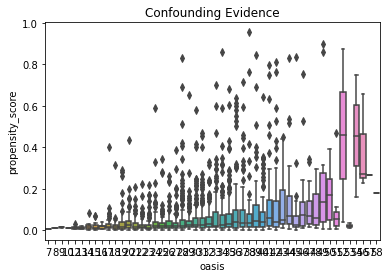

In [ ]:
sns.boxplot(x="oasis", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

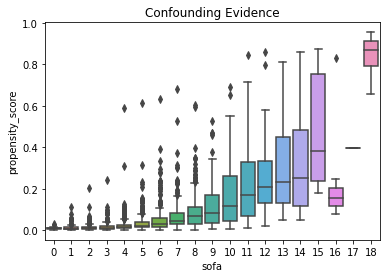

In [ ]:
sns.boxplot(x="sofa", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

Now I use bootstrapping method to get the standard error as well as the significace level for ATT, ATU and ATT.

In [ ]:
# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(X, df[T]).predict_proba(X)[:, 1]
    data_ps = df.assign(propensity_score=ps)
    weight_t = 1/data_ps.query("vaso==1")["propensity_score"]
    y1 = sum(data_ps.query("vaso==1")["class"]*weight_t) / len(df)
    return y1 # compute the ATT

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
atts = Parallel(n_jobs=4)(delayed(run_ps)(df0.sample(frac=1, replace=True), X, T, Y) for _ in range(bootstrap_sample))
atts = np.array(atts)

In [ ]:
print(f"ATT: {atts.mean()}")
print(f"95% C.I.: {(np.percentile(atts, 2.5), np.percentile(atts, 97.5))}")
print((np.percentile(atts, 97.5)-atts.mean())/atts.std()) #显著的

ATT: 0.4741845256288551
95% C.I.: (0.3977293831222999, 0.5546916040390297)
2.0126107963713804


In [ ]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(X, df[T]).predict_proba(X)[:, 1]
    data_ps = df.assign(propensity_score=ps)
    weight_nt = 1/(1-data_ps.query("vaso==0")["propensity_score"])
    y0 = sum(data_ps.query("vaso==0")["class"]*weight_nt) / len(df)
    return y0 # compute the ATT

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
atus = Parallel(n_jobs=4)(delayed(run_ps)(df0.sample(frac=1, replace=True), X, T, Y) for _ in range(bootstrap_sample))
atus = np.array(atus)
print(f"ATT: {atus.mean()}")
print(f"95% C.I.: {(np.percentile(atus, 2.5), np.percentile(atus, 97.5))}")
print((np.percentile(atus, 97.5)-atus.mean())/atus.std()) #显著的

ATT: 0.7671771900135389
95% C.I.: (0.7500086349988837, 0.7837742444907942)
1.9348769228711433


In [ ]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(X, df[T]).predict_proba(X)[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(df0.sample(frac=1, replace=True), X, T, Y) for _ in range(bootstrap_sample))
ates = np.array(ates)

In [ ]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: -0.29299266438468363
95% C.I.: (-0.37009019687567296, -0.20882465803150044)


In [ ]:
(np.percentile(ates, 97.5)-ates.mean())/ates.std() #显著的

2.0566513202696615

Check ATT distribution after IPTW

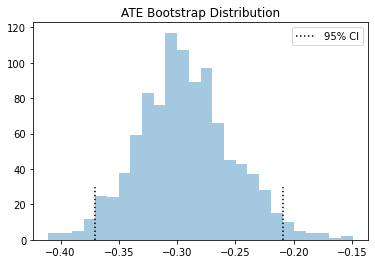

In [ ]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();